In [2]:
import math
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [3]:
epochs = 100
device = torch.device("cpu")

eps = 1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))



def actual_soln(eps):
    return 256*(x**2 + eps**2 * (1 - np.exp(-x/eps))**2 )*((x-1)**2)*(y**2)*((y-1)**2)

In [4]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()
	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		out = x*tanh11*tanh22
		return  out
	
def lag_coeffs(num):
		lis = [np.array([1]),np.array([1,-1])]
		for n in range(1,num-1):
			xl1 = np.concatenate((np.array([0]),lis[n]),axis = 0)
			l1 = np.concatenate((lis[n],np.array([0])),axis = 0)		
			l0 = np.concatenate((lis[n-1],np.array([0,0])),axis = 0)
			l = ((2*n + 1)*l1 - xl1 - n*l0)/(n + 1)
			lis.append(l)
		for n in range(num):
			lis[n] = np.concatenate((lis[n],np.array([0]*(num-1-n))),axis = 0)
		return lis

def poly(coeffs,x):
	sum = torch.zeros_like(x)
	for i,coeff in enumerate(coeffs):
		sum = sum + coeff*(x**i)
	return sum

class Lag_PINN(nn.Module):
	def __init__(self,basis_num):
		super(Lag_PINN,self).__init__()
		self.tanh = nn.Tanh()
		self.basis_num = basis_num
		self.main = nn.Sequential(
			#nn.Linear(2*basis_num,2*basis_num),
			nn.Linear(2*basis_num,1))		
	def forward(self,input):
		tanh1 = self.tanh(input)
		tanh2 = self.tanh(1 - input)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		coeffs = lag_coeffs(self.basis_num)
		x = input[:,0]
		t = input[:,1]
		netin = torch.Tensor([])
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],x.view(-1,1))),1)
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],t.view(-1,1))),1)
		netout = self.main(netin)
		return netout*tanh11*tanh22

In [5]:

def train(device,x,y,eps,learning_rate,epochs,batch_flag,batch_size):
	
	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))
		
	net = FBPINN()# Lag_PINN(10)#FBPINN()#.to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		soln = 256*(xnet**2 + eps**2 * (1 - torch.exp(-xnet/eps))**2 )*((xnet-1)**2)*(ynet**2)*((ynet-1)**2)

		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	losses = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 30:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.10f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,losses 

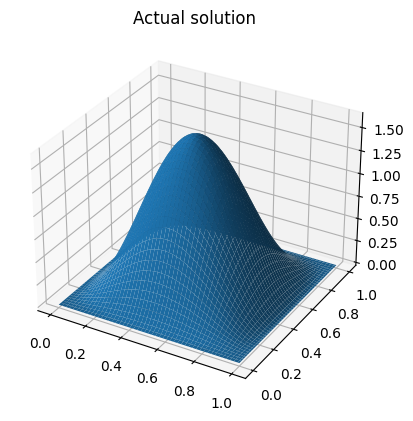

In [6]:
plot_graph(actual_soln(eps),'Actual solution')

78
Train Epoch: 0 	Loss: 6.8038921356
Train Epoch: 0 	Loss: 0.4651512802
Train Epoch: 0 	Loss: 0.0551888682
Train Epoch: 0 	Loss: 0.0248324107

After Epoch 0, 	 Actual solution loss: 0.4274640266



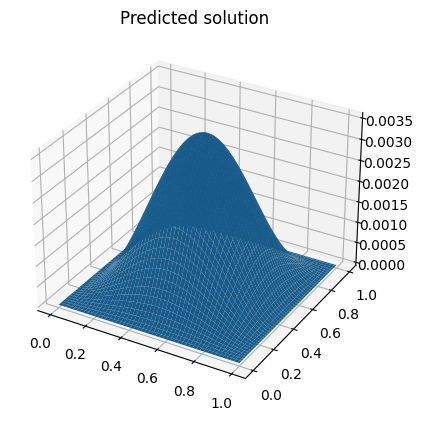

Train Epoch: 1 	Loss: 0.0118869785
Train Epoch: 1 	Loss: 0.0056429347
Train Epoch: 1 	Loss: 0.0035787888
Train Epoch: 1 	Loss: 0.0035342239

After Epoch 1, 	 Actual solution loss: 0.4274769225



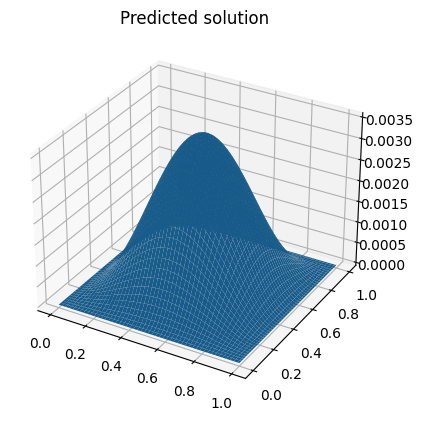

Train Epoch: 2 	Loss: 0.0029044719
Train Epoch: 2 	Loss: 0.0020916883
Train Epoch: 2 	Loss: 0.0020706838
Train Epoch: 2 	Loss: 0.0011062386

After Epoch 2, 	 Actual solution loss: 0.4274753140



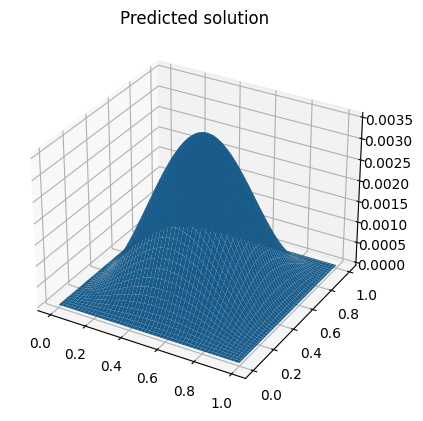

Train Epoch: 3 	Loss: 0.0016125814
Train Epoch: 3 	Loss: 0.0015063320
Train Epoch: 3 	Loss: 0.0014704975
Train Epoch: 3 	Loss: 0.0008166640

After Epoch 3, 	 Actual solution loss: 0.4274711861



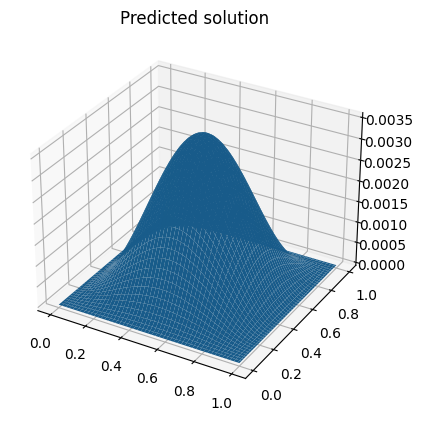

Train Epoch: 4 	Loss: 0.0008837201
Train Epoch: 4 	Loss: 0.0007228740
Train Epoch: 4 	Loss: 0.0006994732
Train Epoch: 4 	Loss: 0.0004308801

After Epoch 4, 	 Actual solution loss: 0.4274717340



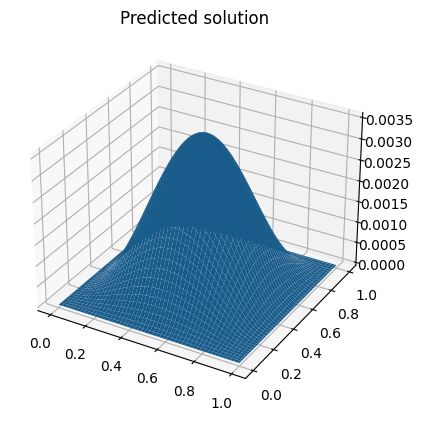

Train Epoch: 5 	Loss: 0.0005103721
Train Epoch: 5 	Loss: 0.0005178061
Train Epoch: 5 	Loss: 0.0003647114
Train Epoch: 5 	Loss: 0.0006752979

After Epoch 5, 	 Actual solution loss: 0.4274780420



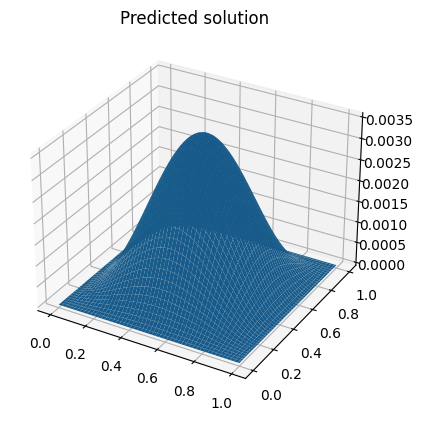

Train Epoch: 6 	Loss: 0.0006340501
Train Epoch: 6 	Loss: 0.0004172905
Train Epoch: 6 	Loss: 0.0001991942
Train Epoch: 6 	Loss: 0.0001666682

After Epoch 6, 	 Actual solution loss: 0.4274716880



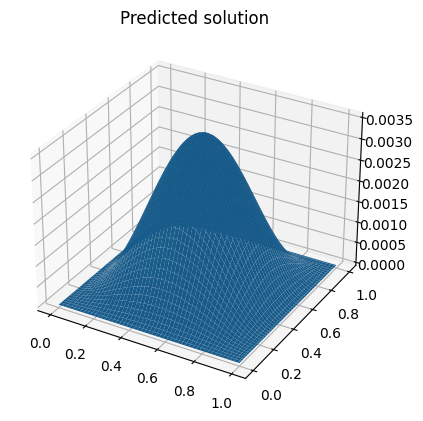

Train Epoch: 7 	Loss: 0.0002471265
Train Epoch: 7 	Loss: 0.0001277507
Train Epoch: 7 	Loss: 0.0002811464
Train Epoch: 7 	Loss: 0.0006433804

After Epoch 7, 	 Actual solution loss: 0.4274810157



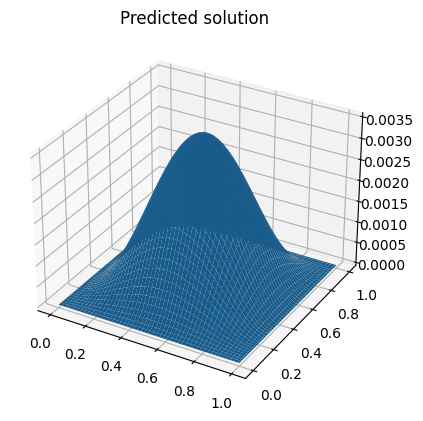

Train Epoch: 8 	Loss: 0.0003004071
Train Epoch: 8 	Loss: 0.0003432453
Train Epoch: 8 	Loss: 0.0003696720
Train Epoch: 8 	Loss: 0.0005076417

After Epoch 8, 	 Actual solution loss: 0.4274643206



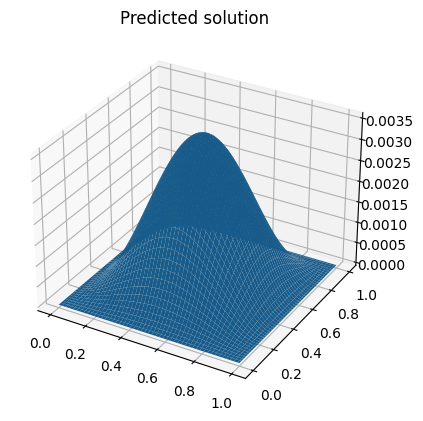

Train Epoch: 9 	Loss: 0.0004132478
Train Epoch: 9 	Loss: 0.0036560050
Train Epoch: 9 	Loss: 0.0005522486
Train Epoch: 9 	Loss: 0.0004523771

After Epoch 9, 	 Actual solution loss: 0.4274902941



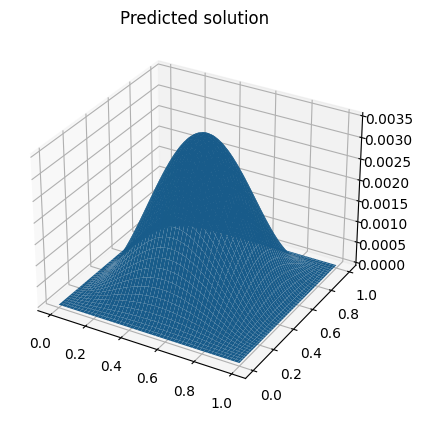

Train Epoch: 10 	Loss: 0.0006828513
Train Epoch: 10 	Loss: 0.0002314911
Train Epoch: 10 	Loss: 0.0002292366
Train Epoch: 10 	Loss: 0.0001493328

After Epoch 10, 	 Actual solution loss: 0.4274993687



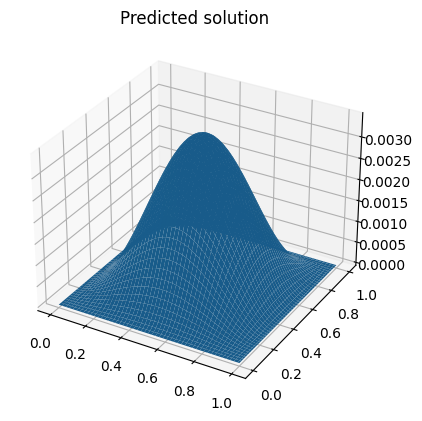

Train Epoch: 11 	Loss: 0.0010789777
Train Epoch: 11 	Loss: 0.0005956978
Train Epoch: 11 	Loss: 0.0004510916
Train Epoch: 11 	Loss: 0.0013617158

After Epoch 11, 	 Actual solution loss: 0.4274828230



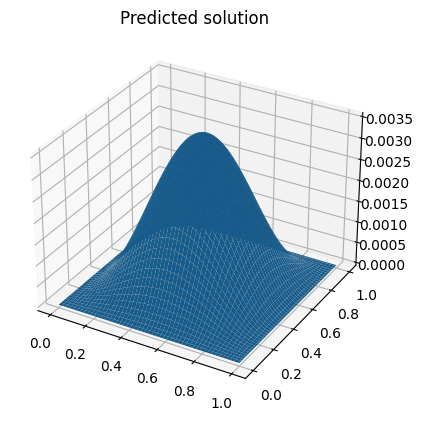

Train Epoch: 12 	Loss: 0.0008020026
Train Epoch: 12 	Loss: 0.0001842053
Train Epoch: 12 	Loss: 0.0000639712
Train Epoch: 12 	Loss: 0.0004033959

After Epoch 12, 	 Actual solution loss: 0.4274788526



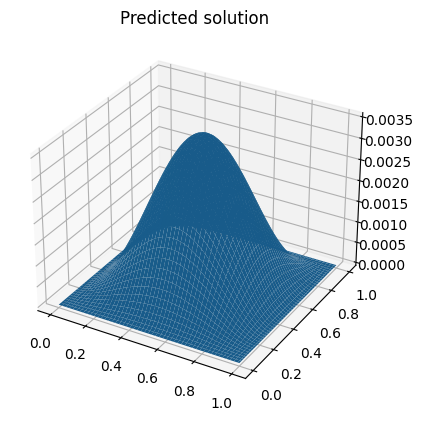

Train Epoch: 13 	Loss: 0.0000871952
Train Epoch: 13 	Loss: 0.0004589897
Train Epoch: 13 	Loss: 0.0002468849
Train Epoch: 13 	Loss: 0.0005396515

After Epoch 13, 	 Actual solution loss: 0.4274823076



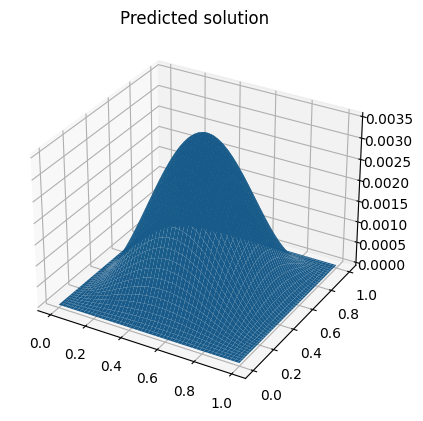

Train Epoch: 14 	Loss: 0.0006028172
Train Epoch: 14 	Loss: 0.0045075747
Train Epoch: 14 	Loss: 0.0015878626
Train Epoch: 14 	Loss: 0.0001897756

After Epoch 14, 	 Actual solution loss: 0.4274642453



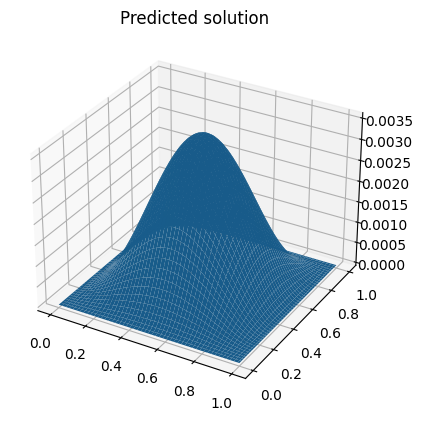

Train Epoch: 15 	Loss: 0.0003469943
Train Epoch: 15 	Loss: 0.0001501464
Train Epoch: 15 	Loss: 0.0002110608
Train Epoch: 15 	Loss: 0.0000283592

After Epoch 15, 	 Actual solution loss: 0.4274715954



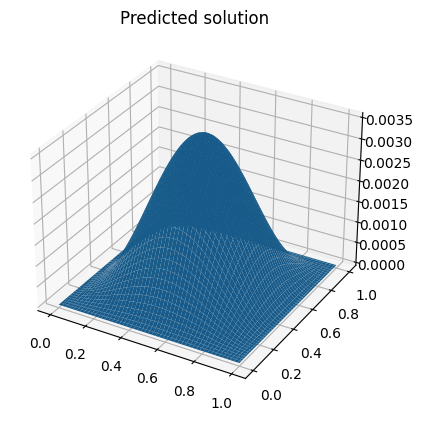

Train Epoch: 16 	Loss: 0.0000220986
Train Epoch: 16 	Loss: 0.0000389639
Train Epoch: 16 	Loss: 0.0001282316
Train Epoch: 16 	Loss: 0.0001414397

After Epoch 16, 	 Actual solution loss: 0.4274771366



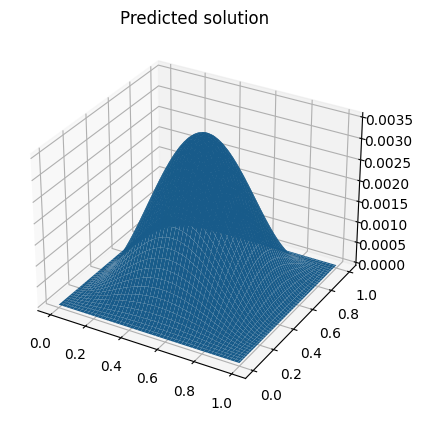

Train Epoch: 17 	Loss: 0.0004764486
Train Epoch: 17 	Loss: 0.0005436815
Train Epoch: 17 	Loss: 0.0005561693
Train Epoch: 17 	Loss: 0.0004352831

After Epoch 17, 	 Actual solution loss: 0.4274740092



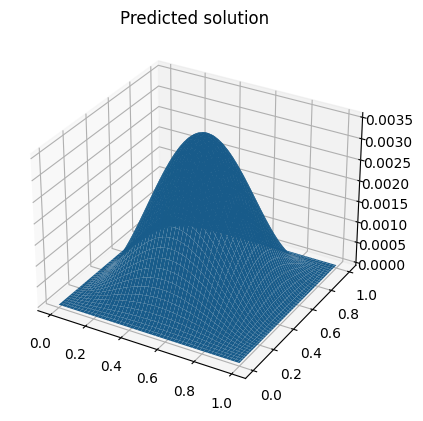

Train Epoch: 18 	Loss: 0.0000409999
Train Epoch: 18 	Loss: 0.0000433002
Train Epoch: 18 	Loss: 0.0000473385
Train Epoch: 18 	Loss: 0.0009715929

After Epoch 18, 	 Actual solution loss: 0.4274957494



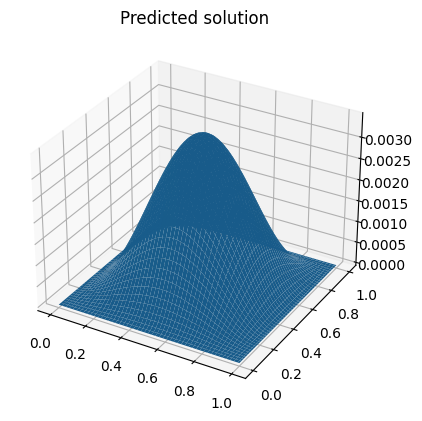

Train Epoch: 19 	Loss: 0.0007524419
Train Epoch: 19 	Loss: 0.0004300816
Train Epoch: 19 	Loss: 0.0003725822
Train Epoch: 19 	Loss: 0.0000735436

After Epoch 19, 	 Actual solution loss: 0.4274829655



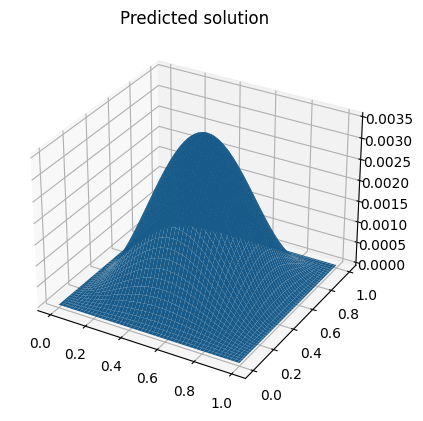

Train Epoch: 20 	Loss: 0.0005219261
Train Epoch: 20 	Loss: 0.0003089393
Train Epoch: 20 	Loss: 0.0001006003
Train Epoch: 20 	Loss: 0.0007413876

After Epoch 20, 	 Actual solution loss: 0.4274729471



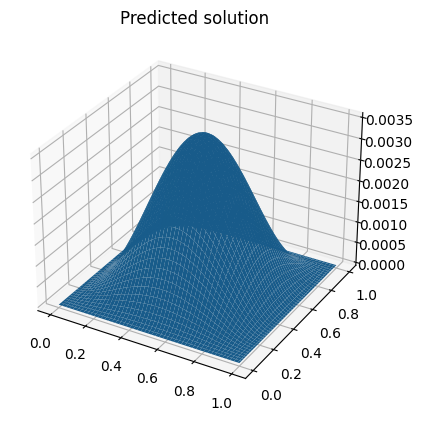

Train Epoch: 21 	Loss: 0.0000445887
Train Epoch: 21 	Loss: 0.0001595235
Train Epoch: 21 	Loss: 0.0000473436
Train Epoch: 21 	Loss: 0.0001957791

After Epoch 21, 	 Actual solution loss: 0.4274795582



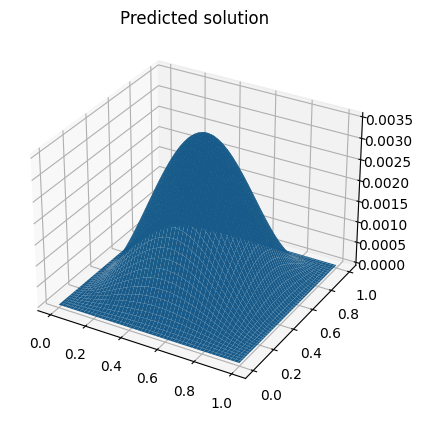

Train Epoch: 22 	Loss: 0.0000894534
Train Epoch: 22 	Loss: 0.0002548042
Train Epoch: 22 	Loss: 0.0007197730
Train Epoch: 22 	Loss: 0.0015674086


: 

In [ ]:
output,losses = train(device,x,y,eps,learning_rate,epochs,batchflag,batchsize)

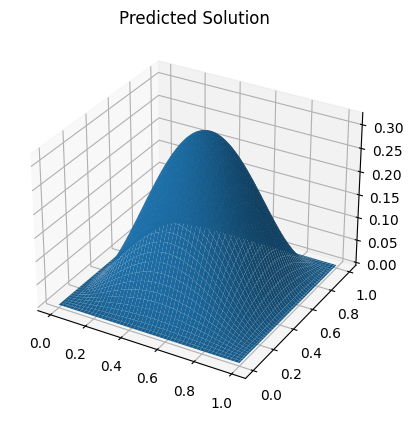

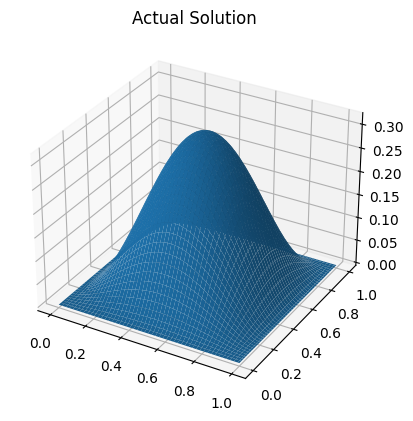

In [ ]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

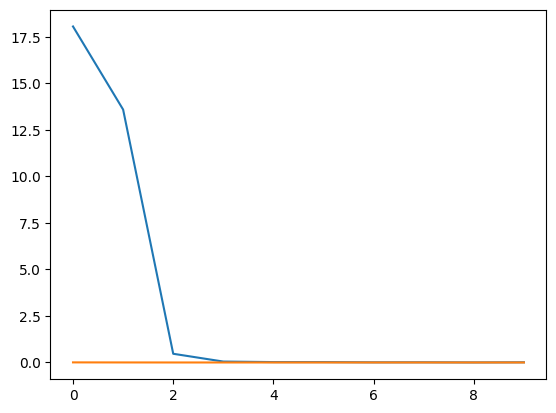

In [ ]:
plt.plot(losses)
plt.show()

In [11]:
import torch

# Create a 1D tensor
x = torch.tensor([1, 2, 3])

# Unsqueeze to add a new dimension (convert to a 2D tensor)
y = x.unsqueeze(0)

print(x)
print(y)

tensor([1, 2, 3])
tensor([[1, 2, 3]])
